# Regular Grid interpolation

When one has a set of models for a set of parameters (i.e. a spectrum for each Teff, log g, Z and alpha) it is likely that given some data on would want to calculate which parameters give rise to a model that is most similar to that data. A good way to do this is to first produce a grid of parameters where at every point of the grid there is a model (that matches the data). This can be done using a interpolation over a regular grid.


# Setting up the model

A model will probably have been computed before one wants to interpolate over it. However for this example we will set up a very simple toy model.

In [41]:
# imports
import numpy as np
from astropy import constants as cc
from astropy import units as u

# some constants
const1 = 8 * np.pi * cc.h * cc.c
const2 = cc.h * cc.c/ cc.k_B
Nlines = 1000
# define some fake lines, with fake centers/heights and widths
xmin, xmax = 10*u.nm, 10000*u.nm
centers = np.array(np.random.uniform(xmin.value, xmax.value, size=Nlines)) * u.nm
heights = np.random.uniform(0.1, 0.5, size=Nlines)
widths = np.random.uniform(0.1, 0.5, size=Nlines)


# Define model functions
def model(Teff, logg, Z, x=None):
    """
    Creates a blackbody spectrum model with fake lines that depend on Teff, logg and Z
    
    :param x: numpy array of quantities, wavelengths
    :param Teff: quantity scalar, temperature in K
    :param logg: float, log 10 of surface gravity (cm/s)
    :param Z: float, metallicity
    
    :return flux: numpy array of 
    """
    # set up some wavelengths
    if x is None:
        x = 10**np.arange(0, 4, 0.001) * u.nm
    # generate some fake lines that depend on Teff logg Z and alpha
    lines = fake_lines(x, Teff, logg, Z)
    # black body curve
    flux = const1.si * (x.si**5 * (np.exp((const2/(x * Teff)).si) - 1))**(-1)
    # return flux with lines added
    return flux.value + lines*flux.value
    
def fake_lines(x, Teff, logg, Z):
    """
    Creates fake lines at "centers" with standard heights and widths 
    defined by "heights" and "widths" they are a (completely fake) function
    of Teff, logg and Z
    
    :param x: numpy array of quantities, wavelengths
    :param Teff: quantity scalar, temperature in K
    :param logg: float, log 10 of surface gravity (cm/s)
    :param Z: float, metallicity
    
    :return profile: numpy array, line transmission profile (fake) 
    """
    # set up a line profile (all ones)
    profile = np.ones_like(x).value
    # get height and widths as functions of Teff, logg, Z and alpha (completely fake)
    itheight = heights + 0.1 * (Teff/(10000.0*u.K)) * (logg/5.0) * (10*Z)
    itwidth = widths * 0.005 * ((1000.0 * u.K) / Teff) * (np.max(x) - np.min(x)) * (logg/5.0)**(-1)
    # loop around line centers and add lines
    for it, center in enumerate(centers):
        width = itwidth[it]
        height = itheight[it]
        # select a small number of x values to compute gaussian
        mask = (x > center - 5 * width) & (x < center + 5 * width)
        # create gaussian line
        exponent = ((x[mask] - center)/(2 *width))**2
        yfit = height * np.exp(-exponent.value)
        # subtract off gaussian line
        profile[mask] -= yfit.value
    # normalise and stick between 0.9 and 1.0
    profile = profile - np.min(profile)
    profile = profile/np.max(profile)
    # return lines
    return profile


Let's test this model below:

/scratch/bin/anaconda3/lib/python3.6/site-packages/astropy/units/quantity.py:641: RuntimeWarning: overflow encountered in exp
  *arrays, **kwargs)


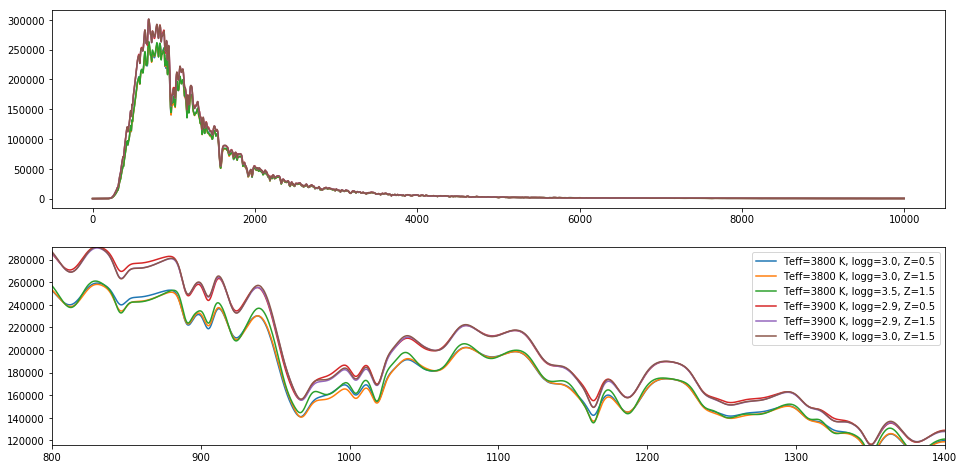

In [43]:
# set up some wavelengths
x = np.arange(0.1, 10000, 0.1)*u.nm
# set up some test parameters
teffs = np.array([3800, 3800, 3800, 3900, 3900, 3900])
loggs = np.array([3.0, 3.0, 3.5, 2.9, 2.9, 3.0])
zs = np.array([0.5, 1.5, 1.5, 0.5, 1.5, 1.5])
# plot
import matplotlib.pyplot as plt

fig, frames = plt.subplots(ncols=1, nrows=2)
fig.set_size_inches(16, 8)

# loop around parameters:
for it in range(len(teffs)):
    # set up the label
    label = 'Teff={0} K, logg={1}, Z={2}'.format(teffs[it], loggs[it], zs[it])
    # get the model data for this iteration
    ymodel = model(teffs[it] * u.K, loggs[it], zs[it], x=x)
    # plot
    frames[0].plot(x, ymodel, label=label)
    frames[1].plot(x, ymodel, label=label)

# zoom in
xmask = (x > 800*u.nm) & (x < 1400*u.nm)
ymax, ymin = np.max(ymodel[xmask]), np.min(ymodel[xmask])
frames[1].set(xlim=(800, 1400), ylim=(ymin, ymax))
# legend
plt.legend(loc=0)
